In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# загружаем подготовленный набор изображений и меток с путями
df = pd.read_csv('data/train_metadata_my.csv')
df.head()

,chip_id,location,datetime,cloudpath,year,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwp,2020,J:\CloudCover\data\data\train_features\adwp\B0...,J:\CloudCover\data\data\train_features\adwp\B0...,J:\CloudCover\data\data\train_features\adwp\B0...,J:\CloudCover\data\data\train_features\adwp\B0...,J:\CloudCover\data\data\train_labels\adwp.tif
1,adwu,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwu,2020,J:\CloudCover\data\data\train_features\adwu\B0...,J:\CloudCover\data\data\train_features\adwu\B0...,J:\CloudCover\data\data\train_features\adwu\B0...,J:\CloudCover\data\data\train_features\adwu\B0...,J:\CloudCover\data\data\train_labels\adwu.tif
2,adwz,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwz,2020,J:\CloudCover\data\data\train_features\adwz\B0...,J:\CloudCover\data\data\train_features\adwz\B0...,J:\CloudCover\data\data\train_features\adwz\B0...,J:\CloudCover\data\data\train_features\adwz\B0...,J:\CloudCover\data\data\train_labels\adwz.tif
3,adxp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adxp,2020,J:\CloudCover\data\data\train_features\adxp\B0...,J:\CloudCover\data\data\train_features\adxp\B0...,J:\CloudCover\data\data\train_features\adxp\B0...,J:\CloudCover\data\data\train_features\adxp\B0...,J:\CloudCover\data\data\train_labels\adxp.tif
4,aeaj,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/aeaj,2020,J:\CloudCover\data\data\train_features\aeaj\B0...,J:\CloudCover\data\data\train_features\aeaj\B0...,J:\CloudCover\data\data\train_features\aeaj\B0...,J:\CloudCover\data\data\train_features\aeaj\B0...,J:\CloudCover\data\data\train_labels\aeaj.tif


In [2]:
def load_chip(row, transforms = None):
    data={
        "chip_id":row.iloc[0],
        "image":None,
        "label":None
    }
    band_arrs = []
    for band in row[5:9]:
        with rasterio.open(band) as b:
            band_arr = b.read(1).astype("float32")
        band_arrs.append(band_arr)
    
    # для меток
    with rasterio.open(row[9]) as lp:
        y_arr = lp.read(1).astype("float32")

    # NDVI = (iRed - Red)/(iRed + Red)индекс растительности
    data['ndvi'] = (band_arrs[3] - band_arrs[2])/(band_arrs[3] + band_arrs[2] + 1)
    
    # NDSI = (Green - iRed)/(Green + iRed)индекс снега
    data['ndsi'] = (band_arrs[1] - band_arrs[3])/(band_arrs[1] + band_arrs[3] + 1)

    x_arr = np.stack(band_arrs, axis=-1)
        
    # Apply data augmentations, if provided
    if transforms:
        t = transforms(image = x_arr, mask = y_arr)
        x_arr = t["image"]
        y_arr = t["mask"] 

    data["image"] = np.transpose(x_arr, [2, 0, 1])
    data["label"] = y_arr
    
    return data

In [23]:
import albumentations as A 

aug = A.SomeOf([
        A.VerticalFlip(p=0.5), 
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.75),
        A.RandomSizedCrop((200,450), 512,512, p=0.7),
        A.Cutout(p=0.7, num_holes=10, max_h_size=40, max_w_size=40)
     ], n=2)

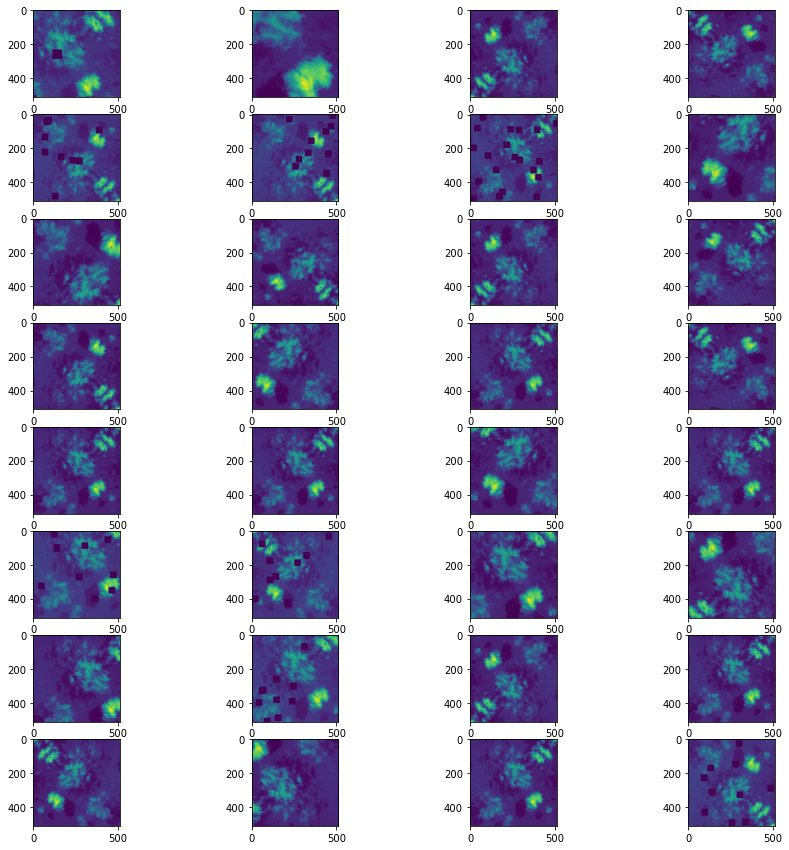

In [25]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15,15))

for i in range(0, 8):
    for j in range(0, 4):
        chip = load_chip(df.iloc[0], transforms=aug)
        axes[i, j].imshow(chip["image"][0]);

In [12]:
chip['image'][0].max()

9600.0

In [4]:
import albumentations as A 

# горизонтальный поворот
a1 = A.HorizontalFlip(p=0.5)
a2 = A.RandomRotate90(p=0.7)
a3 = A.RandomSizedCrop((128,512), 512,512, p=0.5)
a4 = A.Rotate((-30,30))
a5 = A.Blur(0.8)
a6 = A.Normalize()

a_comp = A.SomeOf([a1, a2, a3], n=2)
chip = load_chip(df.iloc[0], transforms=a6)
plt.imshow(chip['image'][0]);

ValueError: operands could not be broadcast together with shapes (512,512,4) (3,) (512,512,4) 

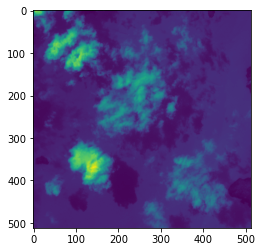

In [19]:
chip = load_chip(df.iloc[0], transforms=a1)
plt.imshow(chip['image'][0]);

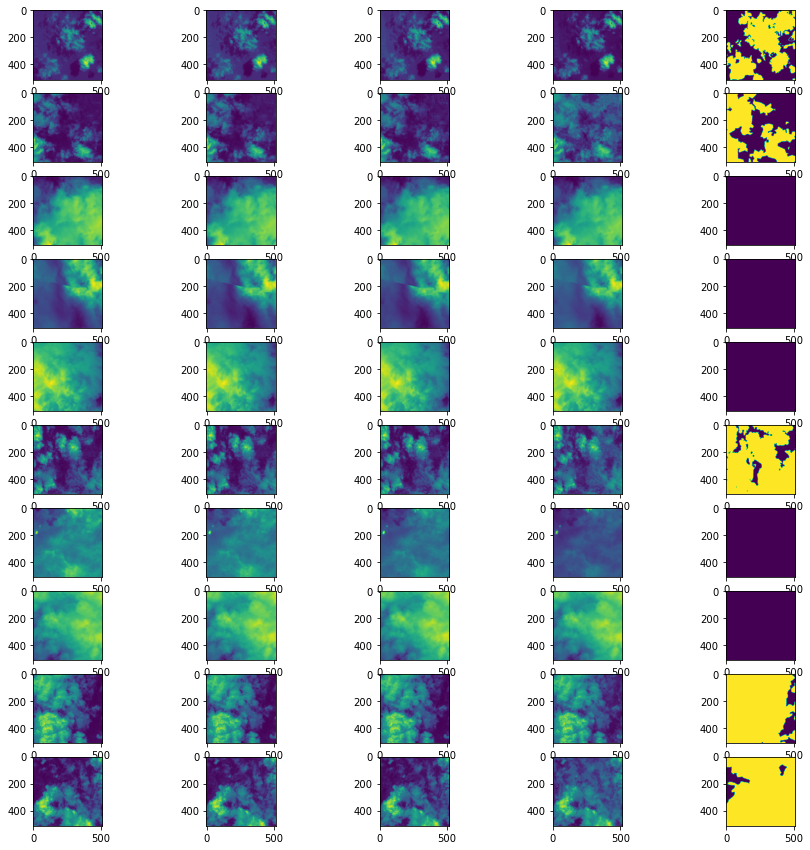

In [13]:
# применение с показом
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(15,15))

for i in range(0, 10):
    chip = load_chip(df.iloc[i], transforms=a_comp)
    axes[i, 0].imshow(chip["image"][0]);
    axes[i, 1].imshow(chip["image"][1]);
    axes[i, 2].imshow(chip["image"][2]);
    axes[i, 3].imshow(chip["image"][3]);
    axes[i, 4].imshow(chip["label"]);

In [ ]:
# прошлый результат 0.876